In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series
        
        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)
            
            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise
            
            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)
            
            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion
            
            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None
    
    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]
    
    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])
            
            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()
            
            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)
            
            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants
    
    return best_params, best_error

In [2]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [3]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.9]
Best error: 0.06772914509380062


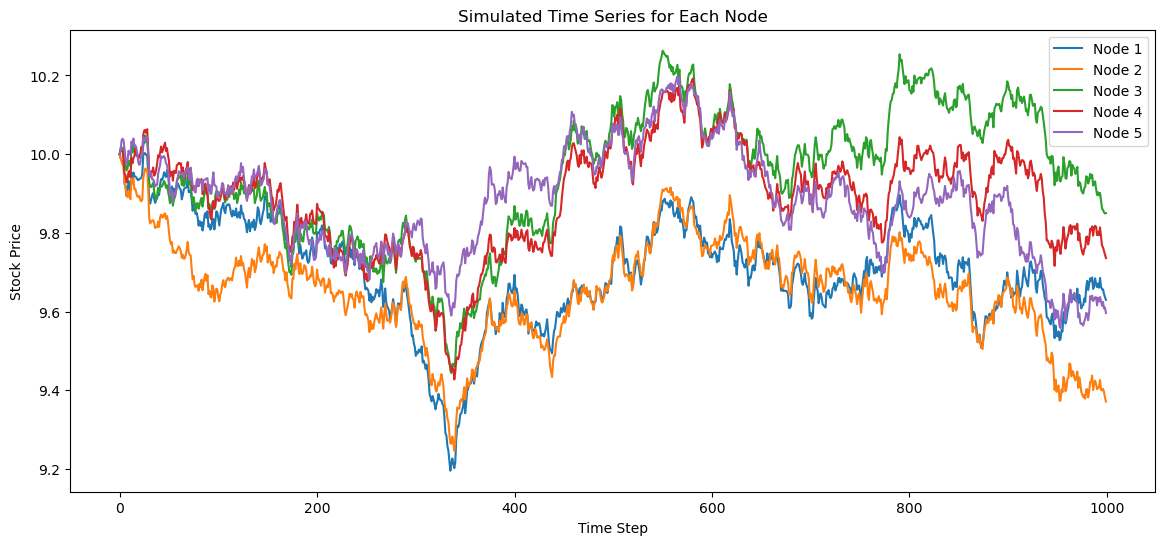

In [4]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

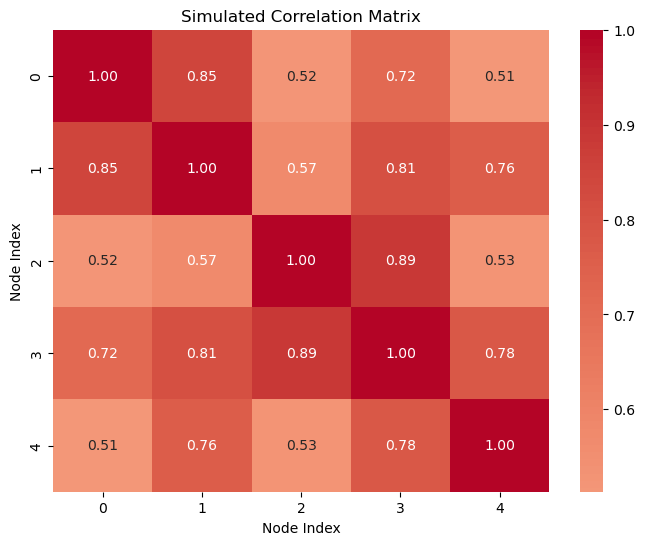

In [5]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [65]:
#Time series of a single node rescaled to match a stock-price
import pandas as pd

# Convert one of the nodes' time series to stock prices
node_index = 3  # Choose the node index to use
price_series = t_series.time_series[node_index]

# Normalize the stock prices to a realistic range
min_price, max_price = 50, 150
normalized_prices = np.interp(price_series, (price_series.min(), price_series.max()), (min_price, max_price))

# Create a date range for one year
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
df = pd.DataFrame(data={'Date': dates, 'StockPrice': normalized_prices})

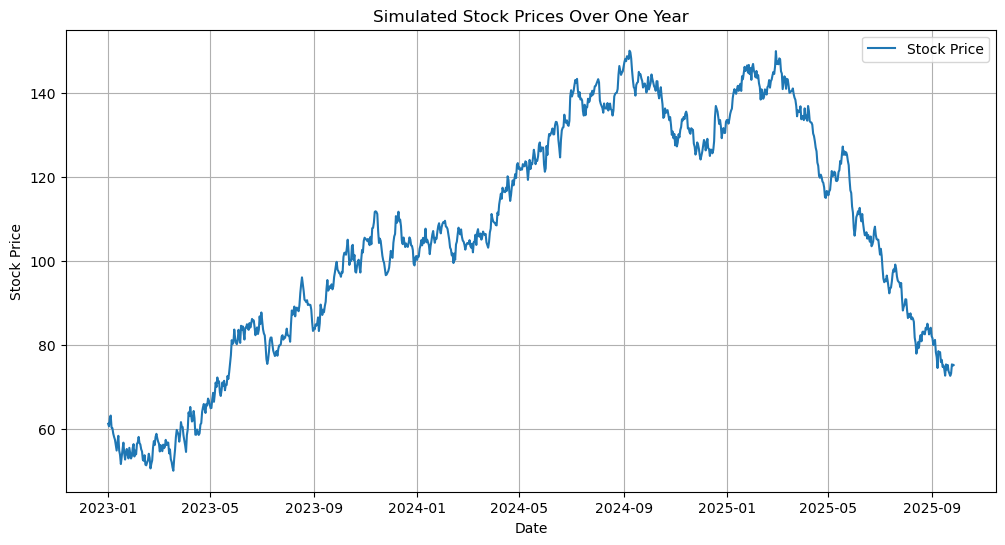

In [117]:
# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['StockPrice'], label='Stock Price')
plt.title('Simulated Stock Prices Over One Year')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
class StockTradingAgent(Agent):
    """An agent that trades stocks."""
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.portfolio = 10000  # Random starting cash
        self.holdings = 0        # Initial stock holdings
        self.buy_threshold = 30  # buy threshold
        self.sell_threshold = 60  # sell threshold
        self.moving_average_period = np.random.randint(5, 15)  # Varying moving average period

    def calculate_rsi(self, prices, period=5):
        """Calculate the Relative Strength Index (RSI) for the given price series."""
        if len(prices) < period:
            return None  # Not enough data to calculate RSI
        
        delta = np.diff(prices[-(period + 1):])  # Get price changes
        gain = np.where(delta > 0, delta, 0).mean()  # Average gain
        loss = -np.where(delta < 0, delta, 0).mean()  # Average loss

        # Avoid division by zero
        if loss == 0:
            return 100 if gain > 0 else 0

        rs = gain / loss  # Relative Strength
        rsi = 100 - (100 / (1 + rs))  # RSI calculation
        return rsi

    def calculate_moving_average(self, prices):
        """Calculate moving average."""
        if len(prices) < self.moving_average_period:
            return None
        return np.mean(prices[-self.moving_average_period:])

    def step(self):
        """Agent's trading behavior at each step."""
        current_step = self.model.schedule.steps
        
        # Ensure current_price is defined
        if current_step < len(self.model.stock_prices):
            current_price = self.model.stock_prices[current_step]
        else:
            current_price = self.model.stock_prices[-1]  # Last price if we run out of stock prices
            
        # Calculate indicators only if enough data is available
        rsi = self.calculate_rsi(self.model.stock_prices[:current_step + 1]) if current_step >= 5 else None
        moving_average = self.calculate_moving_average(self.model.stock_prices[:current_step + 1]) if current_step >= self.moving_average_period else None

        if rsi is None or moving_average is None:
            print(f"Agent {self.unique_id}: Not enough data for RSI or Moving Average.")
            return

        print(f"Agent {self.unique_id}: Current Price = ${current_price:.2f}, RSI = {rsi:.2f}, Moving Average = ${moving_average:.2f}")

        # Implement trading logic based on RSI and Moving Average
        if rsi < self.buy_threshold and self.portfolio >= current_price:  # Buy condition
            shares_to_buy = self.portfolio // current_price // 2  # Buy only half the possible shares
            if shares_to_buy > 0:
                self.holdings += shares_to_buy
                self.portfolio -= shares_to_buy * current_price
                print(f"Agent {self.unique_id} buys {shares_to_buy} shares at ${current_price:.2f}. Portfolio: ${self.portfolio:.2f}, Holdings: {self.holdings} shares.")
        elif rsi > self.sell_threshold and self.holdings > 0:  # Sell condition
            shares_to_sell = self.holdings // 2  # Sell only half the holdings
            self.portfolio += shares_to_sell * current_price
            self.holdings -= shares_to_sell
            print(f"Agent {self.unique_id} sells {shares_to_sell} shares at ${current_price:.2f}. Portfolio: ${self.portfolio:.2f}, Holdings: {self.holdings} shares.")

        # Additional logic: Buy if current price is below moving average and we have cash
        if current_price < moving_average and self.portfolio >= current_price:
            shares_to_buy = self.portfolio // current_price // 2  # Buy half of what can be bought
            if shares_to_buy > 0:
                self.holdings += shares_to_buy
                self.portfolio -= shares_to_buy * current_price
                print(f"Agent {self.unique_id} buys {shares_to_buy} shares below moving average at ${current_price:.2f}. Portfolio: ${self.portfolio:.2f}, Holdings: {self.holdings} shares.")

class StockTradingModel(Model):
    """A model with some number of stock trading agents."""
    
    def __init__(self, num_agents, stock_prices):
        self.num_agents = num_agents
        self.stock_prices = stock_prices
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            agent_reporters={"Portfolio": "portfolio"}
        )

        # Create agents
        for i in range(self.num_agents):
            agent = StockTradingAgent(i, self)
            self.schedule.add(agent)

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()

In [115]:
model = StockTradingModel(num_agents=10, stock_prices=df['StockPrice'])

# Run the model for a specified number of steps
for _ in range(days):
    model.step()

Agent 1: Not enough data for RSI or Moving Average.
Agent 9: Not enough data for RSI or Moving Average.
Agent 7: Not enough data for RSI or Moving Average.
Agent 3: Not enough data for RSI or Moving Average.
Agent 0: Not enough data for RSI or Moving Average.
Agent 5: Not enough data for RSI or Moving Average.
Agent 2: Not enough data for RSI or Moving Average.
Agent 4: Not enough data for RSI or Moving Average.
Agent 8: Not enough data for RSI or Moving Average.
Agent 6: Not enough data for RSI or Moving Average.
Agent 9: Not enough data for RSI or Moving Average.
Agent 7: Not enough data for RSI or Moving Average.
Agent 2: Not enough data for RSI or Moving Average.
Agent 6: Not enough data for RSI or Moving Average.
Agent 5: Not enough data for RSI or Moving Average.
Agent 0: Not enough data for RSI or Moving Average.
Agent 4: Not enough data for RSI or Moving Average.
Agent 8: Not enough data for RSI or Moving Average.
Agent 3: Not enough data for RSI or Moving Average.
Agent 1: Not

Agent 1: Current Price = $54.04, RSI = 53.42, Moving Average = $52.47
Agent 3: Current Price = $54.04, RSI = 53.42, Moving Average = $53.25
Agent 0: Current Price = $54.04, RSI = 53.42, Moving Average = $52.47
Agent 7: Current Price = $54.04, RSI = 53.42, Moving Average = $53.53
Agent 8: Current Price = $54.04, RSI = 53.42, Moving Average = $53.25
Agent 4: Current Price = $54.04, RSI = 53.42, Moving Average = $52.48
Agent 5: Current Price = $54.04, RSI = 53.42, Moving Average = $53.88
Agent 9: Current Price = $54.04, RSI = 53.42, Moving Average = $52.49
Agent 6: Current Price = $54.04, RSI = 53.42, Moving Average = $52.25
Agent 5: Current Price = $53.05, RSI = 70.93, Moving Average = $53.49
Agent 5 sells 101.0 shares at $53.05. Portfolio: $5413.72, Holdings: 101.0 shares.
Agent 5 buys 51.0 shares below moving average at $53.05. Portfolio: $2708.06, Holdings: 152.0 shares.
Agent 0: Current Price = $53.05, RSI = 70.93, Moving Average = $52.57
Agent 0 sells 94.0 shares at $53.05. Portfoli

Agent 5: Current Price = $58.65, RSI = 86.46, Moving Average = $54.99
Agent 5 sells 7.0 shares at $58.65. Portfolio: $12096.19, Holdings: 7.0 shares.
Agent 1: Current Price = $58.65, RSI = 86.46, Moving Average = $56.19
Agent 1 sells 6.0 shares at $58.65. Portfolio: $11069.79, Holdings: 7.0 shares.
Agent 8: Current Price = $58.65, RSI = 86.46, Moving Average = $54.91
Agent 8 sells 7.0 shares at $58.65. Portfolio: $11592.57, Holdings: 7.0 shares.
Agent 0: Current Price = $56.92, RSI = 62.99, Moving Average = $57.18
Agent 0 sells 3.0 shares at $56.92. Portfolio: $11240.55, Holdings: 4.0 shares.
Agent 0 buys 98.0 shares below moving average at $56.92. Portfolio: $5662.27, Holdings: 102.0 shares.
Agent 2: Current Price = $56.92, RSI = 62.99, Moving Average = $56.28
Agent 2 sells 3.0 shares at $56.92. Portfolio: $11529.28, Holdings: 4.0 shares.
Agent 7: Current Price = $56.92, RSI = 62.99, Moving Average = $55.08
Agent 7 sells 3.0 shares at $56.92. Portfolio: $11839.70, Holdings: 4.0 shares

In [116]:
# Print final holdings, portfolio values, and net worth for each agent
print("\nFinal Holdings, Portfolio Values, and Net Worth:")
current_price = np.array(model.stock_prices)[-1]  # Get the last stock price

for agent in model.schedule.agents:
    net_worth = agent.portfolio + (agent.holdings * current_price)  # Calculate net worth
    print(f"Agent {agent.unique_id}: Portfolio = ${agent.portfolio:.2f}, Holdings = {agent.holdings} shares, Net Worth = ${net_worth:.2f}")


Final Holdings, Portfolio Values, and Net Worth:
Agent 4: Portfolio = $12215.22, Holdings = 13.0 shares, Net Worth = $13192.30
Agent 7: Portfolio = $12762.46, Holdings = 13.0 shares, Net Worth = $13739.54
Agent 8: Portfolio = $12476.67, Holdings = 13.0 shares, Net Worth = $13453.75
Agent 3: Portfolio = $12476.67, Holdings = 13.0 shares, Net Worth = $13453.75
Agent 2: Portfolio = $12215.22, Holdings = 13.0 shares, Net Worth = $13192.30
Agent 9: Portfolio = $6009.72, Holdings = 110.0 shares, Net Worth = $14277.31
Agent 5: Portfolio = $13169.84, Holdings = 14.0 shares, Net Worth = $14222.07
Agent 1: Portfolio = $6146.75, Holdings = 112.0 shares, Net Worth = $14564.66
Agent 0: Portfolio = $6146.75, Holdings = 112.0 shares, Net Worth = $14564.66
Agent 6: Portfolio = $5888.12, Holdings = 108.0 shares, Net Worth = $14005.38
